In [1]:
from spreg import OLS
import pysal as ps
import libpysal
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse

/home/maciek/.pyenv/versions/3.8.12/envs/school-map-project/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.10.2-CAPI-1.16.0) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


In [4]:
regression = gpd.read_file('../raw_data/for_models/regression_gdf.shp')

In [5]:
regression.columns

Index(['PLR_ID', 'public_tra', 'eating', 'culture', 'community', 'health_car',
       'public_ser', 'education', 'schools', 'universiti', 'kindergart',
       'outdoor_fa', 'outdoor_le', 'night_life', 'water', 'mig_rate',
       'HK_EU15', 'HK_EU28', 'HK_Polen', 'HK_EheJug', 'HK_EheSU', 'HK_Turk',
       'HK_Arab', 'HK_Sonst', 'HK_NZOrd', 'ave_rent', 'social_hou',
       'public_hou', 'dyn_ew', 'five_y_pls', 'dyn_sales', 'BZR_NAME',
       'child_pov', 'dyn_unempl', 'noise', 'air', 'green', 'bio', 'vegpm20',
       'vegpm10', 'change', 'ch_rate', 'other_sch', 'vocat_sch', 'primary_sc',
       'Gymnasium', 'secon_sch', 'priv_schoo', 'sp_nee_sch', 'kita',
       'stations', 'geometry'],
      dtype='object')

In [6]:
queen = libpysal.weights.Queen.from_dataframe(regression)

In [7]:
queen.weights

{0: [1.0, 1.0, 1.0, 1.0, 1.0],
 1: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 2: [1.0, 1.0, 1.0, 1.0],
 3: [1.0, 1.0, 1.0, 1.0, 1.0],
 4: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 5: [1.0, 1.0, 1.0, 1.0],
 6: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 7: [1.0, 1.0, 1.0, 1.0, 1.0],
 8: [1.0, 1.0, 1.0, 1.0, 1.0],
 9: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 10: [1.0, 1.0, 1.0],
 11: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 12: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 13: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 14: [1.0, 1.0, 1.0, 1.0, 1.0],
 15: [1.0, 1.0, 1.0, 1.0, 1.0],
 16: [1.0, 1.0, 1.0],
 17: [1.0, 1.0, 1.0, 1.0],
 18: [1.0, 1.0, 1.0, 1.0, 1.0],
 19: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 20: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 21: [1.0, 1.0, 1.0],
 22: [1.0, 1.0, 1.0, 1.0, 1.0],
 23: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 24: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 25: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 26: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 27: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 28:

In [9]:
columns = [
    'public_tra', 'eating', 'community', 'education', 'schools', 'kindergart',
    'outdoor_fa', 'outdoor_le', 'night_life', 'ave_rent', 'social_hou',
    'public_hou', 'dyn_ew', 'dyn_sales', 'dyn_unempl', 'noise',
    'air', 'green', 'bio', 'mig_rate'
]

In [10]:
y = np.array(regression['child_pov'])
X = regression[columns].to_numpy()

In [11]:
basic_ols = OLS(y,
                X,
                w=queen,
                name_y='child_pov',
                name_x=columns,
                name_w='Rook',
                name_ds='basic_model',
                white_test=True,
                gwk=queen,
                spat_diag=True,
                moran=True)

In [19]:
regression['residuals'] = basic_ols.u.flatten()

In [31]:
basic_ols.u.flatten().shape

(536,)

In [37]:
list(range(0,536))

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,


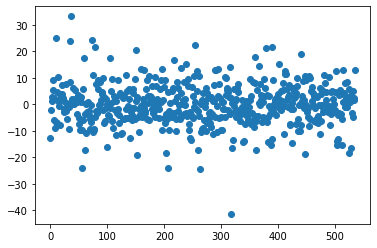

In [39]:
plt.scatter(x= list(range(0,536)), y = basic_ols.u.flatten())

<AxesSubplot:>

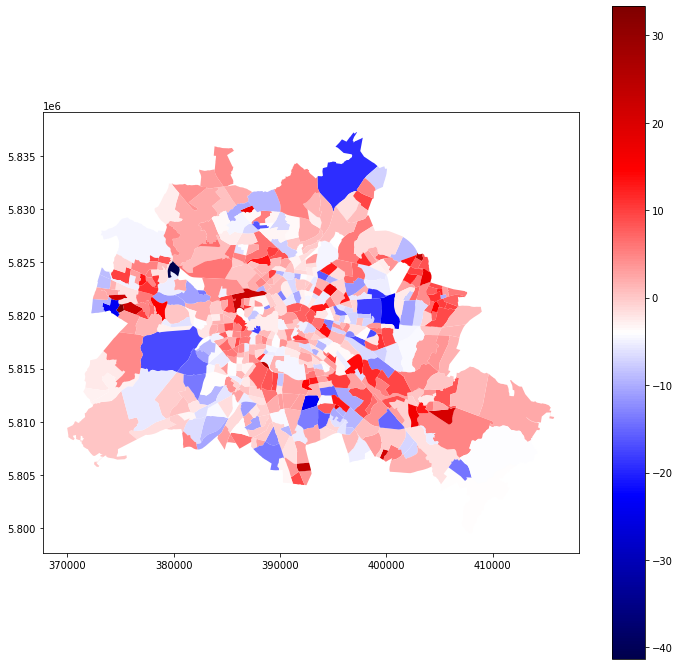

In [25]:
regression.plot(figsize=(12,12), column = 'residuals', cmap='seismic', legend=True)

(array([ 32.,  96., 115.,  92.,  79.,  48.,  37.,  18.,  15.,   4.]),
 array([-1.68571339,  5.56946485, 12.82464309, 20.07982133, 27.33499957,
        34.59017782, 41.84535606, 49.1005343 , 56.35571254, 63.61089078,
        70.86606902]),
 <BarContainer object of 10 artists>)

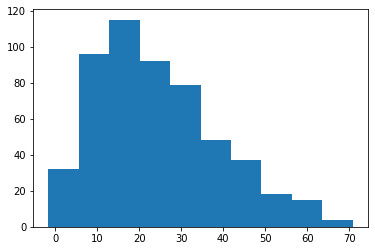

In [24]:
plt.hist(basic_ols.predy.flatten())

<AxesSubplot:>

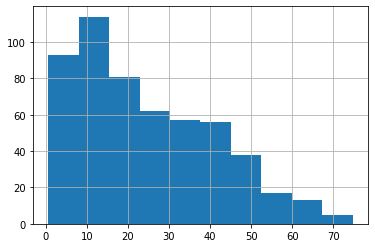

In [19]:
selected['child_pov'].hist()

In [14]:
mae(selected['child_pov'], basic_ols.predy.flatten())

5.77738006106024

In [15]:
np.sqrt(mse(selected['child_pov'], basic_ols.predy.flatten()))

7.797812137434457

In [13]:
print(basic_ols.summary)

REGRESSION
----------
SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            : basic_model
Weights matrix      :        Rook
Dependent Variable  :   child_pov                Number of Observations:         536
Mean dependent var  :     24.5406                Number of Variables   :          21
S.D. dependent var  :     16.6701                Degrees of Freedom    :         515
R-squared           :      0.7808
Adjusted R-squared  :      0.7723
Sum squared residual:   32591.949                F-statistic           :     91.7124
Sigma-square        :      63.285                Prob(F-statistic)     :  3.353e-155
S.E. of regression  :       7.955                Log likelihood        :   -1861.411
Sigma-square ML     :      60.806                Akaike info criterion :    3764.822
S.E of regression ML:      7.7978                Schwarz criterion     :    3854.789

-----------------------------------------------------------------------------

In [36]:
y_b = selected['child_pov']
X_b = selected.drop(columns=['child_pov','B_age', 'geometry'])

In [37]:
### Perform permutation
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression
#fit model
model = LinearRegression().fit(X_b,y_b)
#Perform permutation
permutation_score = permutation_importance(model, X_b,y_b, n_repeats=100)
#Unstack results, put in df
importance_df = pd.DataFrame(np.vstack((X_b.columns,permutation_score.importances_mean)).T)
importance_df.columns=['feature','feature importance']
#Order by importance
importance_df.sort_values(by='feature importance', ascending = False, inplace=True)
importance_df
#remove feature that have lower feature importance, run the validation score to test the reduced feature

,feature,feature importance
25,mig_rate,0.721565
20,dyn_unempl,0.201193
1,eating,0.143608
12,night_life,0.059587
16,public_hou,0.037298
14,ave_rent,0.035973
6,education,0.019695
19,dyn_sales,0.018766
17,dyn_ew,0.01768
24,bio,0.015145


In [69]:
medians = selected[columns].merge(
    selected.groupby('ave_rent').residual.median().to_frame(
        'av_rent_residual'),
    how='left',
    left_on='ave_rent',
    right_index=True).sort_values('av_rent_residual').drop(columns=[
        'public_tra', 'eating', 'community', 'education', 'schools',
        'kindergart', 'outdoor_fa', 'outdoor_le', 'night_life', 'social_hou',
        'public_hou', 'dyn_ew', 'dyn_sales', 'dyn_unempl', 'noise', 'air',
        'green', 'bio', 'mig_rate'
    ])

In [13]:
selected['residual'] = basic_ols.u

In [72]:
medians['ave_rent'].round().value_counts()

9.0     100
11.0     98
8.0      93
10.0     83
13.0     43
12.0     39
14.0     26
15.0     19
7.0      17
16.0     16
1.0       1
4.0       1
Name: ave_rent, dtype: int64

In [70]:
merged_medians['ave_rent'] = medians['ave_rent'].round()

In [71]:
merged_medians = merged_medians.groupby('ave_rent').av_rent_residual.median().to_frame('av_rent_residual')

ValueError: 'ave_rent' is both an index level and a column label, which is ambiguous.

<AxesSubplot:xlabel='ave_rent'>

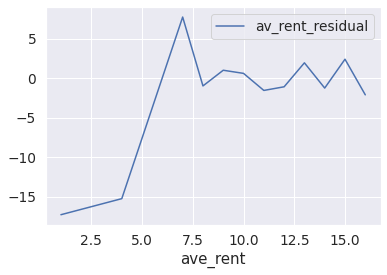

In [63]:
merged_medians.plot()

In [105]:
clusters = list(np.append(importance_df.head(8).feature.values, ('child_pov')))

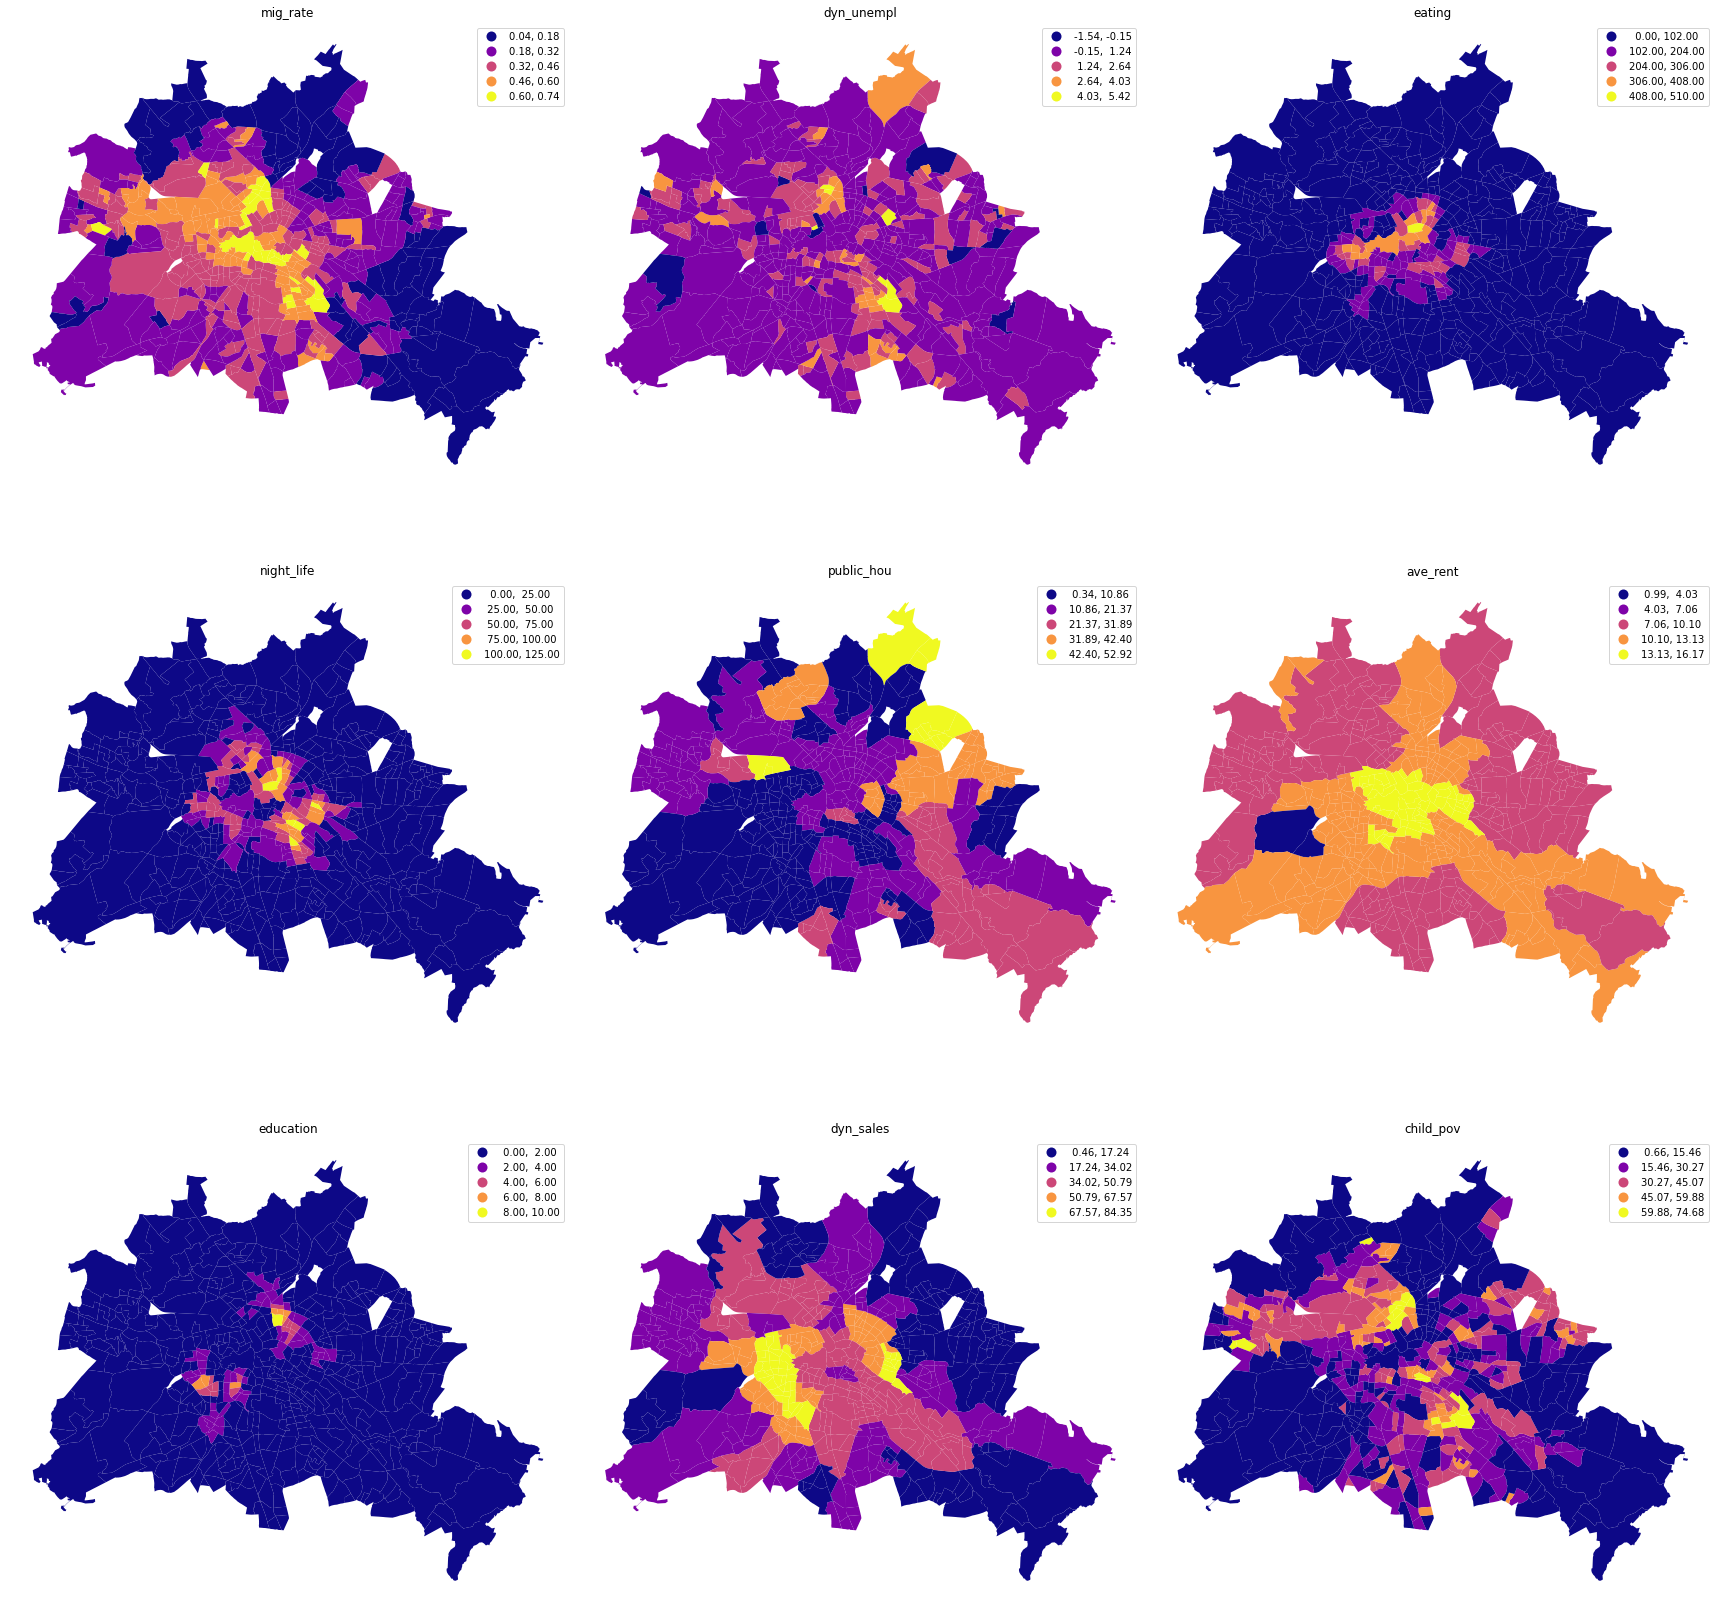

In [107]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
# Make the axes accessible with single indexing
axs = axs.flatten()
# Start a loop over all the variables of interest
for i, col in enumerate(iterable=clusters):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    selected.plot(
        column=col,
        ax=ax,
        scheme="EqualInterval",
        linewidth=0,
        cmap="plasma",
        legend=True
    )
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)
# Display the figure
f.tight_layout()
plt.show()

In [34]:
queen = libpysal.weights.Queen.from_dataframe(selected)

In [35]:
from esda.moran import Moran

In [36]:
import seaborn

In [108]:
# Set seed for reproducibility
np.random.seed(123456)
# Calculate Moran's I for each variable
mi_results = [
    Moran(selected[variable], queen) for variable in clusters
]
# Structure results as a list of tuples
mi_results = [
    (variable, res.I, res.p_sim)
    for variable, res in zip(clusters, mi_results)
]
# Display on table
table = pd.DataFrame(
    mi_results, columns=["Variable", "Moran's I", "P-value"]
).set_index("Variable")
table

,Moran's I,P-value
Variable,,
mig_rate,0.733919,0.001
dyn_unempl,0.353758,0.001
eating,0.828862,0.001
night_life,0.817334,0.001
public_hou,0.746134,0.001
ave_rent,0.808404,0.001
education,0.729361,0.001
dyn_sales,0.832748,0.001
child_pov,0.519632,0.001


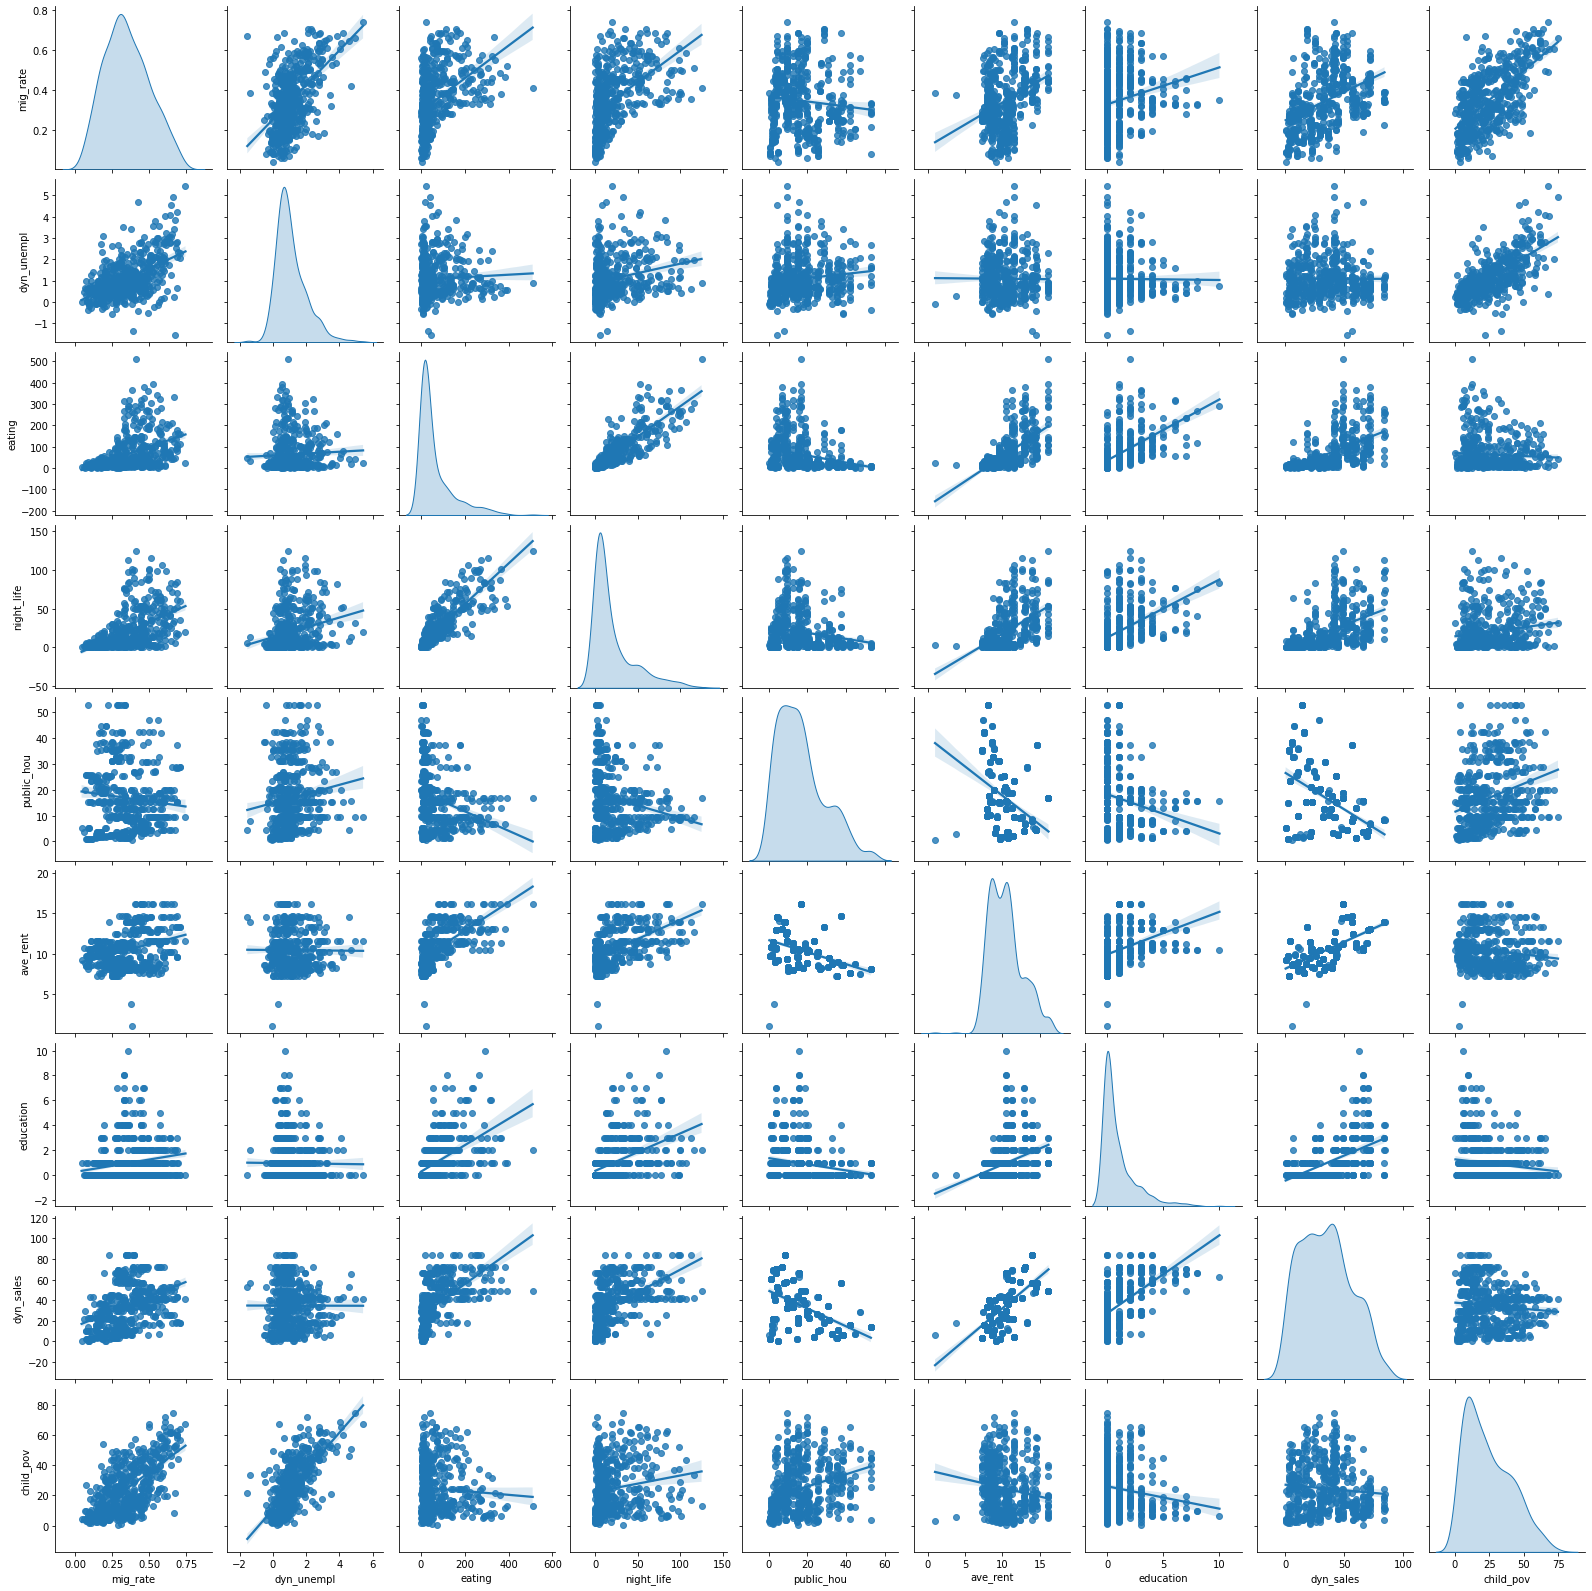

In [109]:
_ = seaborn.pairplot(
    selected[clusters], kind="reg", diag_kind="kde"
)

In [39]:
from sklearn.preprocessing import robust_scale

In [110]:
db_scaled = robust_scale(selected[clusters])

In [111]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
# Set the seed for reproducibility
np.random.seed(1234)
# Run K-Means algorithm
k5cls = kmeans.fit(db_scaled)
k5cls.labels_[:20]

array([2, 3, 0, 1, 0, 2, 0, 0, 2, 2, 2, 3, 2, 0, 3, 1, 2, 0, 2, 3],
      dtype=int32)

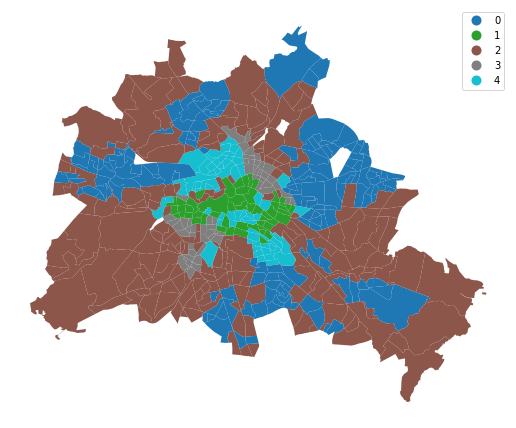

In [115]:
# Assign labels into a column
selected["k5cls"] = k5cls.labels_
# Setup figure and ax
f, ax = plt.subplots(1, figsize=(9, 9))
# Plot unique values choropleth including
# a legend and with no boundary lines
selected.plot(
    column="k5cls", categorical=True, legend=True, linewidth=0, ax=ax
)
# Remove axis
ax.set_axis_off()
# Display the map
plt.show()

In [113]:
# Group table by cluster label, keep the variables used
# for clustering, and obtain their mean
k5means = selected.groupby("k5cls")[clusters].mean()
# Transpose the table and print it rounding each value
# to three decimals
k5means.T.round(3)

k5cls,0,1,2,3,4
mig_rate,0.332,0.466,0.257,0.352,0.570
dyn_unempl,1.345,0.917,0.525,0.840,2.474
eating,15.241,243.942,26.665,131.673,93.299
night_life,6.698,68.038,6.920,34.018,42.985
public_hou,29.035,11.937,10.842,10.799,13.502
ave_rent,8.450,13.847,10.319,11.772,11.777
education,0.160,1.654,0.330,4.618,1.254
dyn_sales,18.143,58.165,32.530,60.912,41.405
child_pov,33.810,19.381,13.552,14.007,47.581


In [114]:
# Group data table by cluster label and count observations
k5sizes = selected.groupby("k5cls").size()
k5sizes

k5cls
0    162
1     52
2    200
3     55
4     67
dtype: int64